Case Study1. Code used to extract data and analyze the outcome. The model itself was run using a script and the command line.

In [22]:

import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
import networkx as nx
import yfinance as yf
import sys
sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg
import port_measures as pm
import matplotlib.pyplot as plt
import tqdm
import scipy

ModuleNotFoundError: No module named 'port_measures'

In [ ]:
def log_lik(mean,cov, X):



    return np.sum(multivariate_normal.logpdf(X, mean=mean, cov=cov, allow_singular=True))

def ebic(mean,cov,prec, X,beta = 0.5):
    
    n = X.shape[0]
    n_edges = nx.from_numpy_matrix(prec).number_of_edges()
    
    log_lik_val = log_lik(mean,cov, X = X)
    return -2*log_lik_val + np.log(n)*n_edges + 4*n_edges*beta*np.log(prec.shape[0])

Function that takes price

In [ ]:
# Get price
def get_yh_price(ticker_list, start_period = '1052125800', interval = '1wk'):
    
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    
    dataframes_price = []

    for i, ticker in enumerate(ticker_list):
        print(f'{i} of {ticker_list.shape[0]-1}')

        # Price data
        url_price = f"http://query2.finance.yahoo.com/v8/finance/chart/{ticker}?symbol={ticker}&period1={start_period}&period2=9999999999&interval={interval}"
        response = requests.get(url_price, headers=headers)
        if response.ok:
            try:
                dates = pd.DataFrame({'timestamp':response.json()["chart"]["result"][0]["timestamp"]})

                #low, open ,volume, close, high
                df_quote = pd.DataFrame(response.json()["chart"]["result"][0]["indicators"]["quote"][0])
                # ad_close
                df_adjclose = pd.DataFrame(response.json()["chart"]["result"][0]["indicators"]["adjclose"][0])

                tmp_df_price = pd.concat([dates, df_quote,df_adjclose], axis=1)
                tmp_df_price['timestamp'] = pd.to_datetime(tmp_df_price['timestamp'], unit = "s")

            except TypeError:
                continue
            except KeyError:
                continue

            tmp_df_price["ticker"] = ticker
            dataframes_price.append(tmp_df_price)

    df_price = pd.concat(dataframes_price)

    return  df_price




Define ticker list

In [23]:
ticker_list = ['XLE', 'XLF', 'XLU', 'XLI', 'XLK', 'XLV', 'XLY', 'XLP', 'XLB', 'IYR', 'XTL']
# ticker_list = ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADM', 'ADBE', 'ADP', 'AAP', 'AES', 'AFL', 'A', 'AKAM', 'ALK', 'ARE', 'LNT', 'GOOGL', 'AMZN', 'AMCR', 'AMT',
#                    'AMP', 'AMGN', 'BALL', 'BDX', 'WRB', 'BIO', 'TECH', 'BIIB','BA', 'CB']
start_date= "2010-01-01"
end_date="2023-02-01"

data = yf.download(ticker_list, start_date , end_date)


log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
price = data['Adj Close'].iloc[1:]

groups = np.array([0, 2, 0, 0, 2, 2, 1, 1, 0, 2, 1])

[*********************100%***********************]  11 of 11 completed


In [ ]:
# ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Energy', 'Materials', 'Industrials','Utilities' ))] = 0
# ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Communication Services', 'Consumer Discretionary', 'Consumer Staples' ))] = 1
# ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Financials', 'Health Care', 'Information Technology','Real Estate' ))] = 2

In [25]:
log_returns_scaled[ticker_list].copy()

,XLE,XLF,XLU,XLI,XLK,XLV,XLY,XLP,XLB,IYR,XTL
Date,,,,,,,,,,,
2011-01-28,-0.434994,-1.768872,-1.349470,-1.962185,-2.334097,-1.818267,-3.313726,-0.961567,-1.574428,-1.576197,0.000000
2011-01-31,2.828419,0.918810,0.220922,1.137759,0.617487,0.221222,0.215388,-0.345682,1.652506,1.180161,-1.510875
2011-02-01,1.613690,2.051939,1.003789,1.397479,1.678764,1.783235,1.176503,0.724532,2.644236,0.464755,1.432956
2011-02-02,-0.080748,-0.779573,-0.532015,-0.327066,0.189046,-0.341672,-0.292832,-0.378850,-0.177517,0.017145,0.408445
2011-02-03,0.053850,0.060183,0.407082,0.054573,0.150936,0.124393,1.166189,0.516242,0.430530,0.257263,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25,0.011081,0.779519,-1.359775,-0.557491,-0.208748,0.029968,0.509376,0.245760,0.204369,-0.111089,0.139911
2023-01-26,3.108720,0.525506,0.334411,0.547556,1.584507,0.187058,2.025766,-0.355194,0.479206,1.105355,0.800693
2023-01-27,-2.039772,0.000000,0.000000,0.416131,0.417840,-0.682591,2.242830,-0.287805,-0.323207,1.017123,-0.277782


In [26]:
out_dict = {'ticker_list':np.array(ticker_list),
'log_returns_scaled':log_returns_scaled[ticker_list].copy(),
'price':price,
'groups':groups}


In [27]:
import pickle
            
with open(f'../data/case_study_etf/raw_etf2.pkl', 'wb') as handle:
    pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
log_returns_scaled.shape

(3022, 11)

In [56]:
mu = np.mean(log_returns_scaled.iloc[0:100],axis = 0)
S1 = np.cov(np.array(log_returns_scaled[0:100]-mu).T)
S2 = np.cov(np.array(log_returns_scaled[0:100]).T)

In [6]:
# import requests
# response = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies" )
# ticker_data = pd.read_html(response.content)[0]
# ticker_data['group'] = 0
# ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Energy', 'Materials', 'Industrials','Utilities' ))] = 0
# ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Communication Services', 'Consumer Discretionary', 'Consumer Staples' ))] = 1
# ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Financials', 'Health Care', 'Information Technology','Real Estate' ))] = 2


# rndstate = np.random.RandomState(6)
# index = rndstate.choice(np.array(range(500)),size = 60,replace=False)
# ticker_list = np.array(ticker_data['Symbol'].iloc[index]).tolist()
# groups_according_to_ticker = np.array(ticker_data['group'].iloc[index])

# start_date= "2016-01-01"
# end_date="2023-02-01"

# import yfinance as yf
# data = yf.download(ticker_list, start_date , end_date)

# log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
# log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
# price = data['Adj Close'].iloc[1:]

# # reorder 
# 
#  according to log_returns scaled as they are in alphabetical order
# groups = np.array([j for _,j in sorted(zip(ticker_list, groups_according_to_ticker))])  

C:\Users\User\AppData\Local\Temp\ipykernel_16056\2650013280.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Energy', 'Materials', 'Industrials','Utilities' ))] = 0
C:\Users\User\AppData\Local\Temp\ipykernel_16056\2650013280.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Communication Services', 'Consumer Discretionary', 'Consumer Staples' ))] = 1
C:\Users\User\AppData\Local\Temp\ipykernel_16056\2650013280.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

[*********************100%***********************]  60 of 60 completed


In [7]:
for i in range(len(ticker_list)):
    print(scipy.stats.normaltest(log_returns_scaled.iloc[:,i]))

NormaltestResult(statistic=251.57557542325443, pvalue=2.349946126607226e-55)
NormaltestResult(statistic=271.60779548718824, pvalue=1.0498242225442411e-59)
NormaltestResult(statistic=541.4362795036318, pvalue=2.682907840634754e-118)
NormaltestResult(statistic=419.14016185139013, pvalue=9.657623753918298e-92)
NormaltestResult(statistic=502.09867071566055, pvalue=9.346714316248763e-110)
NormaltestResult(statistic=372.36388090481046, pvalue=1.3874285642842015e-81)
NormaltestResult(statistic=482.08592080242795, pvalue=2.0719172019724973e-105)
NormaltestResult(statistic=322.41877222748417, pvalue=9.719707144338482e-71)
NormaltestResult(statistic=232.07255154954998, pvalue=4.037250810656872e-51)
NormaltestResult(statistic=431.7869482621771, pvalue=1.732429243147417e-94)
NormaltestResult(statistic=333.14553256202595, pvalue=4.553724673077054e-73)
NormaltestResult(statistic=439.4474277436121, pvalue=3.7601357317590515e-96)
NormaltestResult(statistic=368.4541918247658, pvalue=9.799159533732952e-

In [46]:
obs_per_graph = 120
upr = 500
l = 20
groups = np.array(range(len(ticker_list)))
max_iter = 100
alphas =  [0.0001]
kappas = [1]

pbar = tqdm.tqdm(total = len(range(500, 1600, l))*len(alphas))

sharpes = {i: [] for i in range(len(kappas))}
ebics = {i: [] for i in range(len(kappas))}
mdds = {i: [] for i in range(len(alphas))}
port_price_n = {i: [] for i in range(len(alphas))}
port_price_t = {i: [] for i in range(len(alphas))}

theta_init = None
for alpha_cnt, alpha in enumerate(alphas):

    for i in range(500, 1600, l):
        lwr = np.max((i-500,0))
        nr_graphs = int(np.ceil((i-lwr-obs_per_graph)/l +1))
        kappa = 0.3*np.array([0.9**(pwr) for pwr in range(nr_graphs)])
        kappa_gamma = kappa
        pbar.set_description(f"i {i}")
        mu = np.mean(log_returns_scaled.iloc[lwr:i],axis = 0)
        dg_opt_n = dg.dygl(obs_per_graph = obs_per_graph, max_iter = max_iter, lamda = obs_per_graph*alpha, kappa = obs_per_graph*kappa, kappa_gamma=obs_per_graph*kappa_gamma, 
                        tol = 1e-10, X_type = 'rolling-window', l = l)
        dg_opt_n.fit(np.array(log_returns_scaled[lwr:i]-mu), groups=groups, nr_workers=1, temporal_penalty="element-wise", lik_type="t", nu = None,verbose=False)
        precision_matrix = dg_opt_n.theta[-1]
        #precision_matrix[np.abs(precision_matrix)<1e-2]= 0.0
        S = np.linalg.inv(precision_matrix)*dg_opt_n.nu[-1]/(dg_opt_n.nu[-1]-2)
        mu = np.mean(log_returns_scaled,axis = 0)
        w, mu_p, var_p = pm.portfolio_opt(S,precision_matrix, mu, log_returns_scaled, type = 'sharpe')
        portfolio = np.dot(price.iloc[i:i + l],w)
        port_price_t[alpha_cnt].append(portfolio)
        log_returns_p = np.array(100*np.log(1+pd.DataFrame(portfolio).pct_change()).dropna())
        r_p = (portfolio[-1]-portfolio[0])/portfolio[0]
        sigma_p = np.std(log_returns_p)
        sharpe = pm.sharpe(r_p,sigma_p)
        mdd = pm.max_drawdown(portfolio)
        omega = pm.omega(np.squeeze(log_returns_p/100))
        #print("-------\n")
        #print(f'{np.round(sharpe,3)} {np.round(mdd,5)} {np.round(sigma_p,3)} {np.round(omega,3)}')


        dg_opt_n = dg.dygl(obs_per_graph = obs_per_graph, max_iter = max_iter, lamda = obs_per_graph*alpha, kappa = obs_per_graph*kappa, kappa_gamma=obs_per_graph*kappa_gamma, 
                        tol = 1e-10, X_type = 'rolling-window', l = l)
        dg_opt_n.fit(np.array(log_returns_scaled[lwr:i]-mu), groups=groups, nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian", nu = None,verbose=False)
        precision_matrix = dg_opt_n.theta[-1]
        #precision_matrix[np.abs(precision_matrix)<1e-2]= 0.0
        S = np.linalg.inv(precision_matrix)
        mu = np.mean(log_returns_scaled,axis = 0)
        w, mu_p, var_p = pm.portfolio_opt(S,precision_matrix, mu, log_returns_scaled, type = 'sharpe')
        portfolio = np.dot(price.iloc[i:i + l],w)
        port_price_n[alpha_cnt].append(portfolio)
        log_returns_p = np.array(100*np.log(1+pd.DataFrame(portfolio).pct_change()).dropna())
        r_p = (portfolio[-1]-portfolio[0])/portfolio[0]
        sigma_p = np.std(log_returns_p)
        sharpe = pm.sharpe(r_p,sigma_p)
        mdd = pm.max_drawdown(portfolio)
        omega = pm.omega(np.squeeze(log_returns_p/100))
        #print(f'{np.round(sharpe,3)} {np.round(mdd,5)} {np.round(sigma_p,3)} {np.round(omega,3)}')
        #print("-------\n")
        pbar.update()

pbar.close()





i 500:   0%|          | 0/55 [00:00<?, ?it/s]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:278: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")
i 1580: 100%|██████████| 55/55 [01:43<00:00,  1.89s/it]


In [42]:
pbar.close()

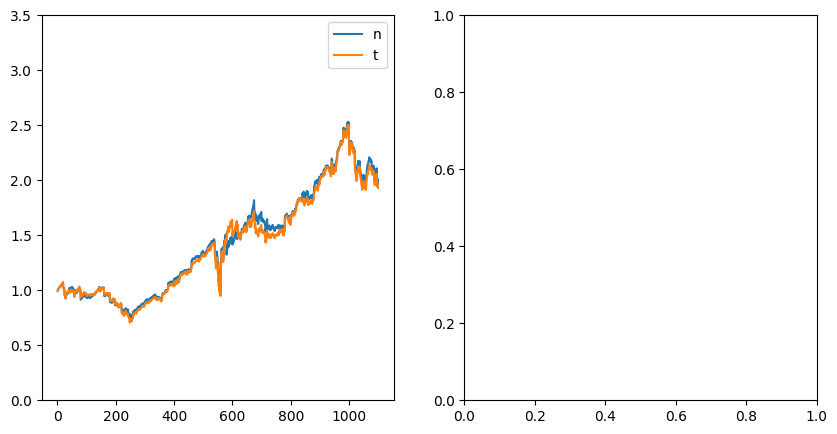

In [47]:
fig, ax = plt.subplots(1,len(alphas)+1, figsize = (10,5))

for k in range(len(alphas)):

    gt_price_n = np.cumprod(1+pd.DataFrame(np.concatenate(port_price_n[k])).pct_change().dropna())
    gt_price_t = np.cumprod(1+pd.DataFrame(np.concatenate(port_price_t[k])).pct_change().dropna())

    ax[k].plot(gt_price_n, label = 'n')
    ax[k].plot(gt_price_t, label = 't')
    ax[k].legend()
    ax[k].set_ylim([0,3.5])

(0.0, 3.5)

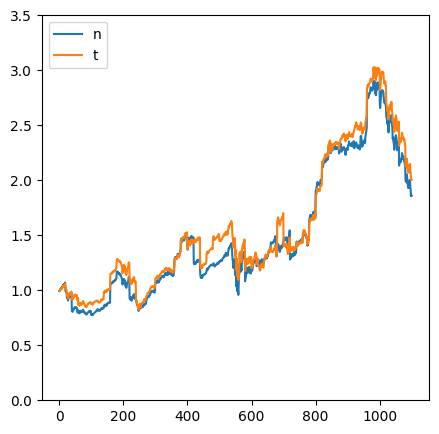

In [33]:

fig, ax = plt.subplots(1,1, figsize = (5,5))
gt_price_n = np.cumprod(1+pd.DataFrame(np.concatenate(port_price_n[1])).pct_change().dropna())
gt_price_t = np.cumprod(1+pd.DataFrame(np.concatenate(port_price_t[2])).pct_change().dropna())

ax.plot(gt_price_n, label = 'n')
ax.plot(gt_price_t, label = 't')
ax.legend()
ax.set_ylim([0,3.5])

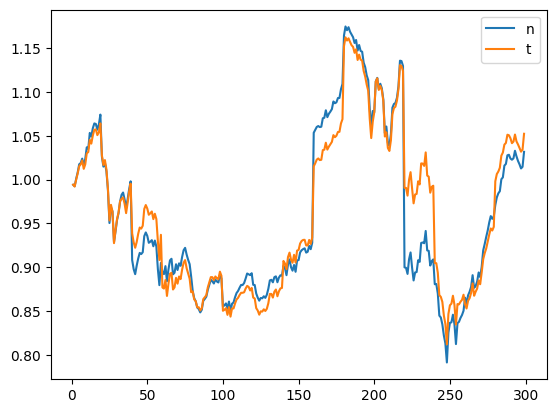

In [12]:
gt_price_n = np.cumprod(1+pd.DataFrame(np.concatenate(port_price_n[0])).pct_change().dropna())
gt_price_t = np.cumprod(1+pd.DataFrame(np.concatenate(port_price_t[0])).pct_change().dropna())

plt.plot(gt_price_n, label = 'n')
plt.plot(gt_price_t, label = 't')
plt.legend()

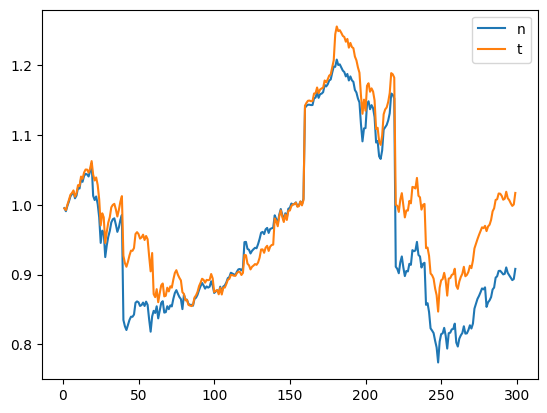

In [10]:
gt_price_n = np.cumprod(1+pd.DataFrame(np.concatenate(port_price_n[0])).pct_change().dropna())
gt_price_t = np.cumprod(1+pd.DataFrame(np.concatenate(port_price_t[0])).pct_change().dropna())

plt.plot(gt_price_n, label = 'n')
plt.plot(gt_price_t, label = 't')
plt.legend()

TypeError: 'AxesSubplot' object is not subscriptable

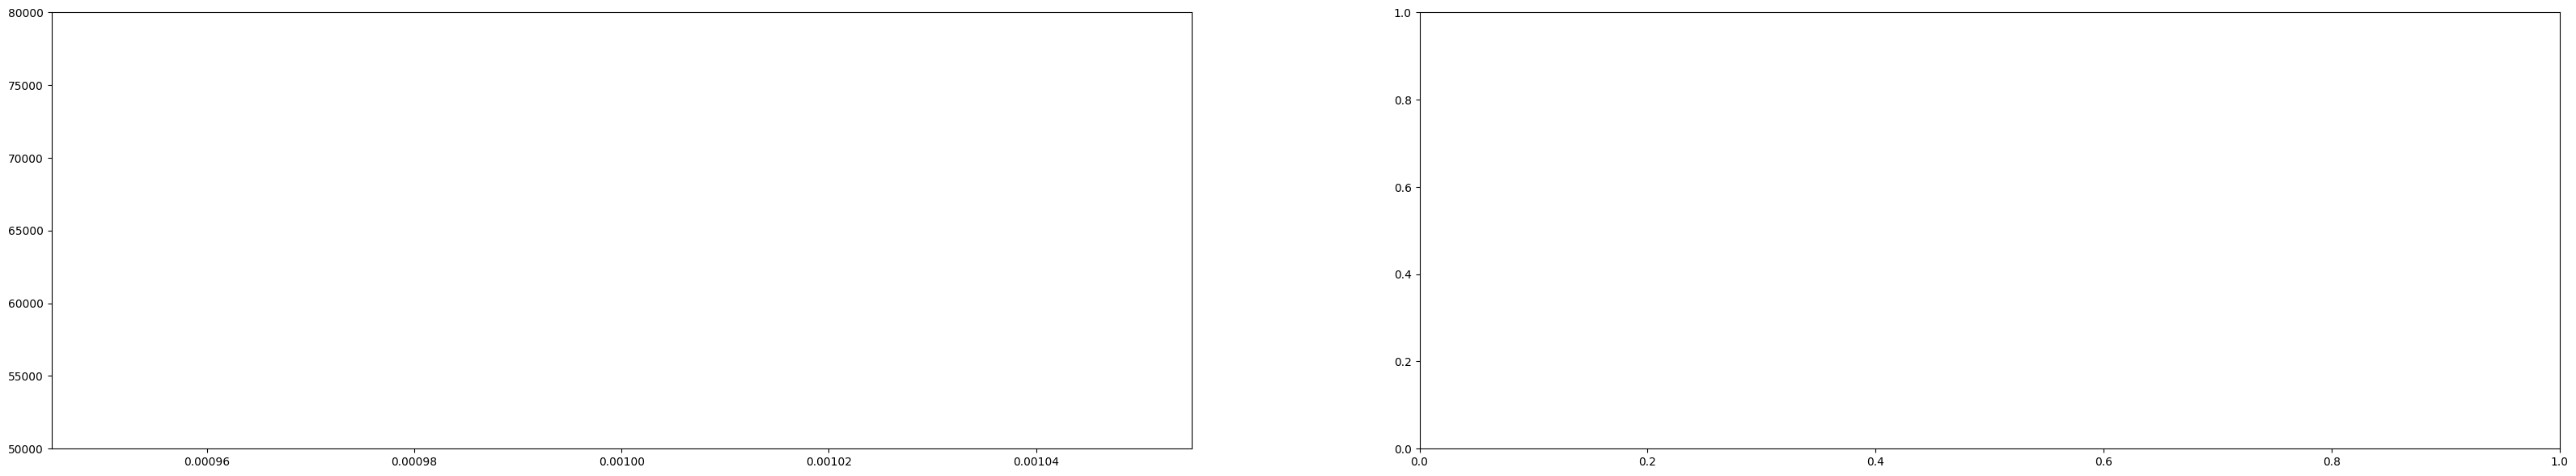

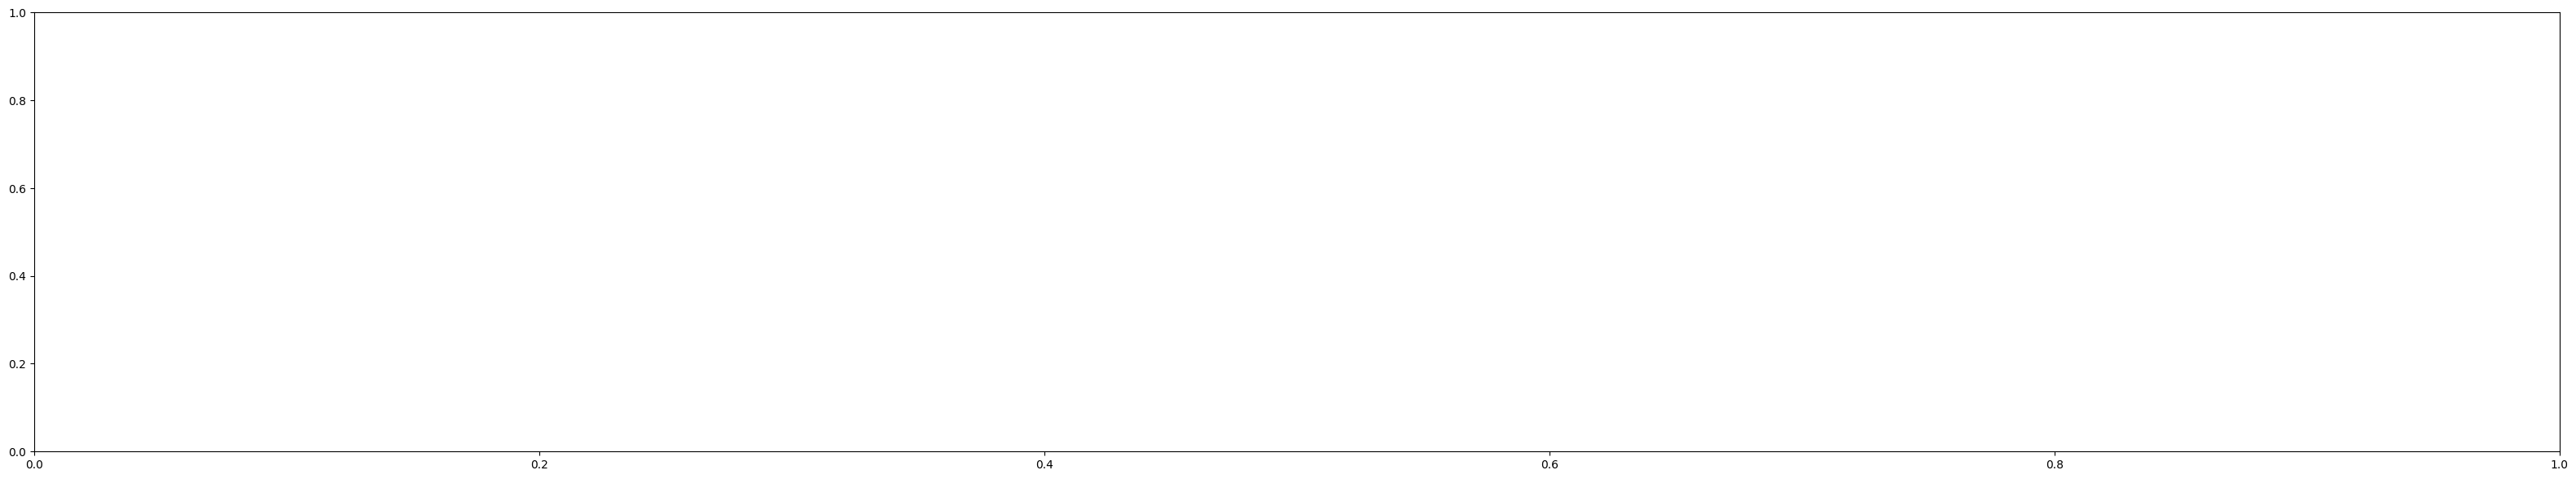

In [15]:
fig, ax = plt.subplots(1,len(kappas), figsize = (40,7))

for i in range(len(kappas)):
    ax[i].plot(alphas, ebics[i])
    ax[i].set_ylim([50_000, 80_000])


fig, ax = plt.subplots(1,len(kappas), figsize = (40,7))

for i in range(len(kappas)):
    ax[i].plot(alphas, sharpes[i])
    ax[i].set_ylim([-0.05,0.05])


fig, ax = plt.subplots(1,len(kappas), figsize = (40,7))
for i in range(len(kappas)):
    ax[i].plot(alphas, mdds[i])
    ax[i].set_ylim([-0.2,0])

In [63]:
obs_per_graph = 100
upr = 500
mu = np.mean(log_returns_scaled,axis = 0)
dg_opt_t = dg.dygl(obs_per_graph = obs_per_graph, max_iter = 1000, lamda = obs_per_graph*0.01, kappa = obs_per_graph*0.1, kappa_gamma=obs_per_graph*0.1, tol = 1e-8)
dg_opt_t.fit(log_returns_scaled[:upr]-mu, nr_workers=6, temporal_penalty="element-wise", lik_type="t", nu = 4)

precision_matrix = dg_opt_t.theta[-1]
precision_matrix[np.abs(precision_matrix)<1e-2]= 0.0
S = np.linalg.inv(precision_matrix)
mu = np.mean(log_returns_scaled,axis = 0)


print(ebic(np.zeros(S.shape[0]),S, precision_matrix, log_returns_scaled, beta = 0.5))

w, mu_p, var_p = pm.portfolio_opt(S,precision_matrix, mu, log_returns_scaled, type = 'sharpe')

portfolio = np.dot(price.iloc[upr:upr + obs_per_graph],w)
log_returns_p = np.array(100*np.log(1+pd.DataFrame(portfolio).pct_change()).dropna())
r_p = (portfolio[-1]-portfolio[0])/portfolio[0]
print(r_p)
sigma_p = np.std(log_returns_p)
sharpe = pm.sharpe(r_p,sigma_p)
print(sharpe)
mdd = pm.max_drawdown(portfolio)
print(mdd)

Error 5.48E-3: 100%|██████████| 1000/1000 [00:05<00:00, 176.01it/s]


73135.72570105425
0.0360036784438555
0.030229392852742853
-0.11090891376754153
